In [1]:
import numpy as np

import dreamcoder as dc
from dreamcoder.domains.quantum_algorithms.primitives import *
from dreamcoder.domains.quantum_algorithms.tasks import *

import time
from tqdm import trange
import random

%autoreload 2
%load_ext line_profiler

### Testing some circuits

In [2]:

n_qubit = 2
full_circuit = (n_qubit,
           (("cnot", 0, 1),
           ("swap", 0, 1),
           ("hadamard", 1))
)

In [3]:
tensor = eye(n_qubit)
tensor_to_mat(swap(cnot(tensor,0,1),0,1))

array([[1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.]], dtype=float16)

In [4]:
full_circuit

(2, (('cnot', 0, 1), ('swap', 0, 1), ('hadamard', 1)))

In [5]:
full_circuit_to_mat(full_circuit)

array([[ 0.707,  0.707,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.707,  0.707],
       [ 0.   ,  0.   ,  0.707, -0.707],
       [ 0.707, -0.707,  0.   ,  0.   ]], dtype=float16)

In [6]:
print_circuit(full_circuit)

                  
q_0: ──■───X──────
     ┌─┴─┐ │ ┌───┐
q_1: ┤ X ├─X─┤ H ├
     └───┘   └───┘


In [7]:
with QiskitTester(full_circuit) as QT:
    QT.circuit.cnot(QT.q(0),QT.q(1))
    QT.circuit.swap(QT.q(0),QT.q(1))
    QT.circuit.h(QT.q(1))
print(QT)
QT.check()

     ┌───┐   ┌───┐
q_0: ┤ X ├─X─┤ H ├
     └─┬─┘ │ └───┘
q_1: ──■───X──────
                  


Code consistent with Qiskit


In [8]:
n_qubit= 3
code = dc.program.Program.parse("(lambda (cnot (minv(mv $0))))")
code.infer()
code.evaluate([])(no_op(n_qubit))

((1, -1, 3), (('cnot', 1, 0),))

In [9]:
code.evaluate([])(no_op(n_qubit))

((1, -1, 3), (('cnot', 1, 0),))

In [10]:
state_circuit_to_mat(code.evaluate([])(no_op(n_qubit)))

array([[1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.]], dtype=float16)

### Testing some Tasks

In [11]:
tasks = makeTasks()

In [12]:
task = get_task_from_name("hadamard_0",tasks)
code = dc.program.Program.parse("(lambda (h $0))")
task.logLikelihood(code),  grammar.logLikelihood(code.infer(), code)


(0.0, -4.1588830833596715)

In [13]:
task =get_task_from_name("cnot_01",tasks)
code = dc.program.Program.parse("(lambda (cnot $0))")
task.logLikelihood(code), grammar.logLikelihood(code.infer(), code)

(0.0, -4.1588830833596715)

In [14]:
task = get_task_from_name("cnot_10",tasks)
code = dc.program.Program.parse("(lambda (cnot (minv(mv $0))))")
task.logLikelihood(code),  grammar.logLikelihood(code.infer(), code)


(0.0, -8.317766166719343)

In [15]:
task = get_task_from_name("swap_01",tasks)
code = dc.program.Program.parse("(lambda  (cnot(minv(mv_r(cnot(minv (mv (cnot $0))))))))")
task.logLikelihood(code),  grammar.logLikelihood(code.infer(), code)


(0.0, -16.635532333438686)

In [72]:
code = dc.program.Program.parse("(lambda  (mv(mv(cnot(minv(mv_r(cnot(minv (mv (cnot $0))))))))))")
code.evaluate([])(no_op(3))


((2, 1, 3), (('cnot', 0, 1), ('cnot', 1, 0), ('cnot', 0, 1)))

In [97]:
# Testing embedding primitive
code = dc.program.Program.parse("(lambda (mv (emb (lambda  (mv(mv(cnot(minv(mv_r(cnot(minv (mv (cnot $0))))))))))  $0 )))")

code.evaluate([])(no_op(3))

((1, 1, 3), (('cnot', 0, 1), ('cnot', 1, 0), ('cnot', 0, 1)))

In [34]:
task = get_task_from_name("cz_01",tasks)
code = dc.program.Program.parse("(lambda (h(mv(cnot(mv_r(h (mv $0)))))))")
task.logLikelihood(code),  grammar.logLikelihood(code.infer(), code)
np.round(state_circuit_to_mat(code.evaluate([])(no_op(2))),decimals=2)

array([[ 1.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.],
       [ 0.,  0.,  1.,  0.],
       [ 0.,  0.,  0., -1.]], dtype=float16)

In [35]:
with QiskitTester(code.evaluate([])(no_op(3))) as QT:
    QT.circuit.cz(QT.q(0),QT.q(1))
print(QT)
QT.check()
np.real(np.array(QT.result))

        
q_0: ───
        
q_1: ─■─
      │ 
q_2: ─■─
        


Code consistent with Qiskit


array([[ 1.,  0.,  0.,  0.,  0.,  0., -0., -0.],
       [ 0.,  1.,  0.,  0.,  0.,  0., -0., -0.],
       [ 0.,  0.,  1.,  0.,  0.,  0., -0., -0.],
       [ 0.,  0.,  0.,  1.,  0.,  0., -0., -0.],
       [ 0.,  0.,  0.,  0.,  1.,  0., -0., -0.],
       [ 0.,  0.,  0.,  0.,  0.,  1., -0., -0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., -1., -0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., -0., -1.]])

In [36]:
with QiskitTester(code.evaluate([])(no_op(2))) as QT:
    QT.circuit.cz(QT.q(1),QT.q(0))
print(QT)
np.real(np.array(QT.result))

        
q_0: ─■─
      │ 
q_1: ─■─
        


array([[ 1.,  0.,  0., -0.],
       [ 0.,  1.,  0., -0.],
       [ 0.,  0.,  1., -0.],
       [ 0.,  0.,  0., -1.]])

In [37]:
task = get_task_from_name("cnot_nn_1",tasks)
code = dc.program.Program.parse("(lambda (cnot ((rep (dec(dec(size $0))) (lambda (mv $0))) $0)))")
code.evaluate([])(no_op(3))
task.logLikelihood(code),  grammar.logLikelihood(code.infer(), code)


(0.0, -15.83434397769155)

In [38]:
task = get_task_from_name("swap_0n",tasks)
code = dc.program.Program.parse("(lambda ((  (rep (dec(dec(size $0))) (lambda ((cnot(minv(mv_r(cnot(minv (mv (cnot(mv_r $0)))))))))) )  (mv_r( (rep (dec(size $0)) (lambda (mv((cnot(minv(mv_r(cnot(minv (mv (cnot $0)))))))))) ) $0 )))))")
print_circuit(code.evaluate([])(no_op(3)))
task.logLikelihood(code),  grammar.logLikelihood(code.infer(), code)

          ┌───┐                         ┌───┐     
q_0: ──■──┤ X ├──■───────────────────■──┤ X ├──■──
     ┌─┴─┐└─┬─┘┌─┴─┐     ┌───┐     ┌─┴─┐└─┬─┘┌─┴─┐
q_1: ┤ X ├──■──┤ X ├──■──┤ X ├──■──┤ X ├──■──┤ X ├
     └───┘     └───┘┌─┴─┐└─┬─┘┌─┴─┐└───┘     └───┘
q_2: ───────────────┤ X ├──■──┤ X ├───────────────
                    └───┘     └───┘               


(0.0, -53.633315382926966)

In [39]:
## If swap was included
# task = get_task_from_name("swap_0n",tasks)
# code = dc.program.Program.parse("(lambda ((  (rep (dec(dec(size $0))) (lambda (swap(mv_r $0))) )  (mv_r( (rep (dec(size $0)) (lambda (mv(swap $0))) ) $0 )))))")
# print_circuit(code.evaluate([])(no_op(5)))
# task.logLikelihood(code),  grammar.logLikelihood(code.infer(), code)

In [40]:
## If swap was included
# task = get_task_from_name("swap_0n",tasks)
# code = dc.program.Program.parse("(lambda ((  (rep (dec(dec(size $0))) (lambda (swap(mv_r $0))) )  (mv_r( (rep (dec(size $0)) (lambda (mv(swap $0))) )  $0 )))))")
# print_circuit(code.evaluate([])(no_op(5)))
# task.logLikelihood(code),  grammar.logLikelihood(code.infer(), code)

### Profile bottom-up enumeration

In [13]:
try:
    import binutil  # required to import from dreamcoder modules
except ModuleNotFoundError:
    import bin.binutil  # alt import if called as module

from dreamcoder.domains.quantum_algorithms.main import main
from dreamcoder.dreamcoder import commandlineArguments
from dreamcoder.utilities import numberOfCPUs

arguments = commandlineArguments(
    featureExtractor=None, # it was TowerCNN
    CPUs=numberOfCPUs(),
    helmholtzRatio=0.5,
    recognitionTimeout=6,
    iterations=6,
    a=3,
    structurePenalty=1,
    pseudoCounts=10,
    topK=2,
    maximumFrontier=5,
    extras=None,
    solver="bottom", 
    useRecognitionModel=False,
    enumerationTimeout=6,#-g
    compressor="pypy")   #ocaml, python, pypy  


CUDA is available?: False
using cuda?: False


usage: ipykernel_launcher.py [-h] [--resume RESUME] [-i ITERATIONS]
                             [-t ENUMERATIONTIMEOUT] [-R RECOGNITIONTIMEOUT]
                             [-RS RECOGNITIONSTEPS] [-k TOPK]
                             [-p PSEUDOCOUNTS] [-b AIC] [-l STRUCTUREPENALTY]
                             [-a ARITY] [-c CPUS] [--no-cuda]
                             [-m MAXIMUMFRONTIER] [--reuseRecognition]
                             [--recognition] [--ensembleSize ENSEMBLESIZE]
                             [-g] [-d] [--no-consolidation]
                             [--testingTimeout TESTINGTIMEOUT]
                             [--testEvery TESTEVERY] [--seed SEED]
                             [--activation {relu,sigmoid,tanh}]
                             [--solver {ocaml,pypy,bottom,python}]
                             [-r HELMHOLTZRATIO]
                             [--compressor {pypy,rust,vs,pypy_vs,ocaml,memorize}]
                             [--matrixRank MATRIXRANK] 

In [14]:
# %lprun -f dc.domains.quantum_algorithms.primitives.tensor_contraction -f dc.domains.quantum_algorithms.tasks.QuantumTask.logLikelihood -f dc.domains.quantum_algorithms.primitives.execute_quantum_algorithm -f full_circuit_to_mat -f dc.enumeration.multicoreEnumeration main(arguments)
main(arguments)

Running EC on 01-mar-grp-0020 @ 2022-04-03 20:06:17.653038 with 8 CPUs and parameters:
	 noConsolidation  =  False
	 iterations  =  6
	 enumerationTimeout  =  6
	 useRecognitionModel  =  False
	 topk_use_only_likelihood  =  False
	 pseudoCounts  =  10
	 aic  =  1.0
	 structurePenalty  =  1
	 arity  =  3
	 taskReranker  =  default
	 storeTaskMetrics  =  True
	 rewriteTaskMetrics  =  False
	 maximumFrontier  =  5
	 solver  =  bottom
	 topK  =  2
	 evaluationTimeout  =  0.01
	 cuda  =  False

Currently using this much memory: 208424960
Currently using this much memory: 208429056
Using a waking task batch of size: 19
Disabling parallelism on the Python side because we only have one job.
If you are using ocaml or bottom, there could still be parallelism.
(frontend) Launching int -> tcircuit (19 tasks) w/ 8 CPUs. 0.000000 <= MDL < 6.000000. Timeout 6.000000.
PANIC! Exception in child worker: [Errno 2] No such file or directory: 'pypy3': 'pypy3'
Traceback (most recent call last):
  File "/Use

AssertionError: 

In [43]:
code = dc.program.Program.parse("(lambda ((rep (inc(inc(dec 0))) (lambda (mv $0))) $0))")
code.evaluate([])(no_op(5))
code.infer()
tasks[0].logLikelihood(code),  grammar.logLikelihood(code.infer(), code)


(-inf, -13.328818040700815)

## Recognition model

In [44]:
print(grammar)

continuation : tcircuit
0.000000	t0	$_
0.000000	tcircuit -> tcircuit	mv
0.000000	tcircuit -> tcircuit	mv_r
0.000000	tcircuit -> tcircuit	minv
0.000000	tcircuit -> tcircuit	h
0.000000	tcircuit -> tcircuit	cnot
0.000000	int -> (tcircuit -> tcircuit) -> tcircuit -> tcircuit	rep
0.000000	int	0
0.000000	int -> int	inc
0.000000	int -> int	dec
0.000000	tcircuit -> int	size


In [101]:
restricted_pcfg = dc.grammar.PCFG.from_grammar(grammar, request=dc.type.arrow(tcircuit, tcircuit))
full_pcfg = dc.grammar.PCFG.from_grammar(full_grammar, request=dc.type.arrow(tcircuit_full, tcircuit_full))

pcfg compilation: distinct non terminals 2 ; distinct environments 2
pcfg compilation: distinct non terminals 2 ; distinct environments 2


In [102]:
iterator = restricted_pcfg.quantized_enumeration(observational_equivalence=False)

In [103]:
for i in range(200):
    print(next(iterator))

start symbol: (tcircuit, (tcircuit,))

(tcircuit, (tcircuit,)) ::= mv	0x(tcircuit, (tcircuit,))		-2.0794415416798357
(tcircuit, (tcircuit,)) ::= mv_r	0x(tcircuit, (tcircuit,))		-2.0794415416798357
(tcircuit, (tcircuit,)) ::= minv	0x(tcircuit, (tcircuit,))		-2.0794415416798357
(tcircuit, (tcircuit,)) ::= h	0x(tcircuit, (tcircuit,))		-2.0794415416798357
(tcircuit, (tcircuit,)) ::= cnot	0x(tcircuit, (tcircuit,))		-2.0794415416798357
(tcircuit, (tcircuit,)) ::= rep	0x(int, (tcircuit,)) 1x(tcircuit, (tcircuit,)) 0x(tcircuit, (tcircuit,))		-2.0794415416798357
(tcircuit, (tcircuit,)) ::= emb	1x(tcircuit, (tcircuit,)) 0x(tcircuit, (tcircuit,))		-2.0794415416798357
(tcircuit, (tcircuit,)) ::= $0			-2.0794415416798357

(int, (tcircuit,)) ::= 0			-1.3862943611198906
(int, (tcircuit,)) ::= inc	0x(int, (tcircuit,))		-1.3862943611198906
(int, (tcircuit,)) ::= dec	0x(int, (tcircuit,))		-1.3862943611198906
(int, (tcircuit,)) ::= size	0x(tcircuit, (tcircuit,))		-1.3862943611198906
[(lambda 0)]
 -- Bott

(lambda $0)


 -- Bottom up enumeration, cost 5
 -- Bottom up enumeration, cost 6
 -- Bottom up enumeration, cost 7
 -- Bottom up enumeration, cost 8


(lambda (mv $0))
(lambda (mv_r $0))
(lambda (minv $0))
(lambda (h $0))
(lambda (cnot $0))


 -- Bottom up enumeration, cost 9
 -- Bottom up enumeration, cost 10
 -- Bottom up enumeration, cost 11
 -- Bottom up enumeration, cost 12


(lambda (mv (mv $0)))
(lambda (mv (mv_r $0)))
(lambda (mv (minv $0)))
(lambda (mv (h $0)))
(lambda (mv (cnot $0)))
(lambda (mv_r (mv $0)))
(lambda (mv_r (mv_r $0)))
(lambda (mv_r (minv $0)))
(lambda (mv_r (h $0)))
(lambda (mv_r (cnot $0)))
(lambda (minv (mv $0)))
(lambda (minv (mv_r $0)))
(lambda (minv (minv $0)))
(lambda (minv (h $0)))
(lambda (minv (cnot $0)))
(lambda (h (mv $0)))
(lambda (h (mv_r $0)))
(lambda (h (minv $0)))
(lambda (h (h $0)))
(lambda (h (cnot $0)))
(lambda (cnot (mv $0)))
(lambda (cnot (mv_r $0)))
(lambda (cnot (minv $0)))
(lambda (cnot (h $0)))
(lambda (cnot (cnot $0)))
(lambda (emb (lambda $0) $0))


 -- Bottom up enumeration, cost 13
 -- Bottom up enumeration, cost 14
 -- Bottom up enumeration, cost 15


(lambda (rep 0 (lambda $0) $0))


 -- Bottom up enumeration, cost 16


(lambda (mv (mv (mv $0))))
(lambda (mv (mv (mv_r $0))))
(lambda (mv (mv (minv $0))))
(lambda (mv (mv (h $0))))
(lambda (mv (mv (cnot $0))))
(lambda (mv (mv_r (mv $0))))
(lambda (mv (mv_r (mv_r $0))))
(lambda (mv (mv_r (minv $0))))
(lambda (mv (mv_r (h $0))))
(lambda (mv (mv_r (cnot $0))))
(lambda (mv (minv (mv $0))))
(lambda (mv (minv (mv_r $0))))
(lambda (mv (minv (minv $0))))
(lambda (mv (minv (h $0))))
(lambda (mv (minv (cnot $0))))
(lambda (mv (h (mv $0))))
(lambda (mv (h (mv_r $0))))
(lambda (mv (h (minv $0))))
(lambda (mv (h (h $0))))
(lambda (mv (h (cnot $0))))
(lambda (mv (cnot (mv $0))))
(lambda (mv (cnot (mv_r $0))))
(lambda (mv (cnot (minv $0))))
(lambda (mv (cnot (h $0))))
(lambda (mv (cnot (cnot $0))))
(lambda (mv (emb (lambda $0) $0)))
(lambda (mv_r (mv (mv $0))))
(lambda (mv_r (mv (mv_r $0))))
(lambda (mv_r (mv (minv $0))))
(lambda (mv_r (mv (h $0))))
(lambda (mv_r (mv (cnot $0))))
(lambda (mv_r (mv_r (mv $0))))
(lambda (mv_r (mv_r (mv_r $0))))
(lambda (mv_r (mv_r (minv 

 -- Bottom up enumeration, cost 17
 -- Bottom up enumeration, cost 18


(lambda (rep (inc 0) (lambda $0) $0))
(lambda (rep (dec 0) (lambda $0) $0))


 -- Bottom up enumeration, cost 19


(lambda (mv (rep 0 (lambda $0) $0)))
(lambda (mv_r (rep 0 (lambda $0) $0)))
(lambda (minv (rep 0 (lambda $0) $0)))
(lambda (h (rep 0 (lambda $0) $0)))
(lambda (cnot (rep 0 (lambda $0) $0)))
(lambda (rep 0 (lambda $0) (mv $0)))
(lambda (rep 0 (lambda $0) (mv_r $0)))
(lambda (rep 0 (lambda $0) (minv $0)))
(lambda (rep 0 (lambda $0) (h $0)))
(lambda (rep 0 (lambda $0) (cnot $0)))
(lambda (rep 0 (lambda (mv $0)) $0))
(lambda (rep 0 (lambda (mv_r $0)) $0))
(lambda (rep 0 (lambda (minv $0)) $0))
(lambda (rep 0 (lambda (h $0)) $0))
(lambda (rep 0 (lambda (cnot $0)) $0))
(lambda (rep (size $0) (lambda $0) $0))


 -- Bottom up enumeration, cost 20


(lambda (mv (mv (mv (mv $0)))))
(lambda (mv (mv (mv (mv_r $0)))))
(lambda (mv (mv (mv (minv $0)))))
(lambda (mv (mv (mv (h $0)))))
(lambda (mv (mv (mv (cnot $0)))))
(lambda (mv (mv (mv_r (mv $0)))))
(lambda (mv (mv (mv_r (mv_r $0)))))
(lambda (mv (mv (mv_r (minv $0)))))
(lambda (mv (mv (mv_r (h $0)))))


In [104]:
dc.program.Program.parse("(lambda (mv (h (h  $0))))").evaluate([])(no_op(3))

((1, 1, 3), (('hadamard', 0), ('hadamard', 0)))

In [105]:
iterator = restricted_pcfg.quantized_enumeration(observational_equivalence=True,
                                                 inputs=[[no_op(3)],[no_op(4)]], 
                                                 sound=False)

In [106]:
for i in range(200): 
    print(next(iterator))

start symbol: (tcircuit, (tcircuit,))

(tcircuit, (tcircuit,)) ::= mv	0x(tcircuit, (tcircuit,))		-2.0794415416798357
(tcircuit, (tcircuit,)) ::= mv_r	0x(tcircuit, (tcircuit,))		-2.0794415416798357
(tcircuit, (tcircuit,)) ::= minv	0x(tcircuit, (tcircuit,))		-2.0794415416798357
(tcircuit, (tcircuit,)) ::= h	0x(tcircuit, (tcircuit,))		-2.0794415416798357
(tcircuit, (tcircuit,)) ::= cnot	0x(tcircuit, (tcircuit,))		-2.0794415416798357
(tcircuit, (tcircuit,)) ::= rep	0x(int, (tcircuit,)) 1x(tcircuit, (tcircuit,)) 0x(tcircuit, (tcircuit,))		-2.0794415416798357
(tcircuit, (tcircuit,)) ::= emb	1x(tcircuit, (tcircuit,)) 0x(tcircuit, (tcircuit,))		-2.0794415416798357
(tcircuit, (tcircuit,)) ::= $0			-2.0794415416798357

(int, (tcircuit,)) ::= 0			-1.3862943611198906
(int, (tcircuit,)) ::= inc	0x(int, (tcircuit,))		-1.3862943611198906
(int, (tcircuit,)) ::= dec	0x(int, (tcircuit,))		-1.3862943611198906
(int, (tcircuit,)) ::= size	0x(tcircuit, (tcircuit,))		-1.3862943611198906
[(lambda 0)]
 -- Bott

(lambda $0)


 -- Bottom up enumeration, cost 5
 -- Bottom up enumeration, cost 6
 -- Bottom up enumeration, cost 7
 -- Bottom up enumeration, cost 8


(lambda (mv $0))
(lambda (mv_r $0))
(lambda (minv $0))
(lambda (h $0))
(lambda (cnot $0))


 -- Bottom up enumeration, cost 9
 -- Bottom up enumeration, cost 10
 -- Bottom up enumeration, cost 11
 -- Bottom up enumeration, cost 12


(lambda (mv (mv $0)))
(lambda (mv (minv $0)))
(lambda (mv (h $0)))
(lambda (mv (cnot $0)))
(lambda (mv_r (mv $0)))
(lambda (minv (h $0)))
(lambda (minv (cnot $0)))
(lambda (h (mv $0)))
(lambda (h (cnot $0)))
(lambda (cnot (mv $0)))
(lambda (cnot (h $0)))


 -- Bottom up enumeration, cost 13
 -- Bottom up enumeration, cost 14
 -- Bottom up enumeration, cost 15
 -- Bottom up enumeration, cost 16


(lambda (mv (mv (mv $0))))
(lambda (mv (mv (minv $0))))
(lambda (mv (mv (h $0))))
(lambda (mv (mv (cnot $0))))
(lambda (mv (minv (h $0))))
(lambda (mv (minv (cnot $0))))
(lambda (mv (h (mv $0))))
(lambda (mv (h (cnot $0))))
(lambda (mv (cnot (mv $0))))
(lambda (mv (cnot (h $0))))
(lambda (mv_r (mv (cnot $0))))
(lambda (mv_r (h (mv $0))))
(lambda (mv_r (cnot (mv $0))))
(lambda (minv (mv (minv $0))))
(lambda (minv (mv_r (mv $0))))
(lambda (minv (h (mv $0))))
(lambda (minv (h (cnot $0))))
(lambda (minv (cnot (mv $0))))
(lambda (minv (cnot (h $0))))
(lambda (h (mv (mv $0))))
(lambda (h (mv (h $0))))
(lambda (h (mv (cnot $0))))
(lambda (h (cnot (mv $0))))
(lambda (h (cnot (h $0))))
(lambda (cnot (mv (mv $0))))
(lambda (cnot (mv (minv $0))))
(lambda (cnot (mv (h $0))))
(lambda (cnot (mv (cnot $0))))
(lambda (cnot (h (mv $0))))
(lambda (cnot (h (cnot $0))))


 -- Bottom up enumeration, cost 17
 -- Bottom up enumeration, cost 18
 -- Bottom up enumeration, cost 19
 -- Bottom up enumeration, cost 20


(lambda (mv (mv (mv (minv $0)))))
(lambda (mv (mv (mv (h $0)))))
(lambda (mv (mv (mv (cnot $0)))))
(lambda (mv (mv (minv (h $0)))))
(lambda (mv (mv (minv (cnot $0)))))
(lambda (mv (mv (h (mv $0)))))
(lambda (mv (mv (h (cnot $0)))))
(lambda (mv (mv (cnot (mv $0)))))
(lambda (mv (mv (cnot (h $0)))))
(lambda (mv (minv (mv (minv $0)))))
(lambda (mv (minv (mv_r (mv $0)))))
(lambda (mv (minv (h (mv $0)))))
(lambda (mv (minv (h (cnot $0)))))
(lambda (mv (minv (cnot (mv $0)))))
(lambda (mv (minv (cnot (h $0)))))
(lambda (mv (h (mv (mv $0)))))
(lambda (mv (h (mv (h $0)))))
(lambda (mv (h (mv (cnot $0)))))
(lambda (mv (h (cnot (mv $0)))))
(lambda (mv (h (cnot (h $0)))))
(lambda (mv (cnot (mv (mv $0)))))
(lambda (mv (cnot (mv (minv $0)))))
(lambda (mv (cnot (mv (h $0)))))
(lambda (mv (cnot (mv (cnot $0)))))
(lambda (mv (cnot (h (mv $0)))))
(lambda (mv (cnot (h (cnot $0)))))
(lambda (mv_r (mv (mv (mv $0)))))
(lambda (mv_r (mv (mv (cnot $0)))))
(lambda (mv_r (mv (minv (h $0)))))
(lambda (mv_r (mv (

 -- Bottom up enumeration, cost 21
 -- Bottom up enumeration, cost 22
 -- Bottom up enumeration, cost 23


(lambda (rep (size $0) (lambda (minv $0)) $0))
(lambda (rep (size $0) (lambda (h $0)) $0))
(lambda (rep (size $0) (lambda (cnot $0)) $0))


 -- Bottom up enumeration, cost 24


(lambda (mv (mv (mv (minv (h $0))))))
(lambda (mv (mv (mv (minv (cnot $0))))))
(lambda (mv (mv (mv (h (cnot $0))))))
(lambda (mv (mv (mv (cnot (h $0))))))
(lambda (mv (mv (minv (mv (minv $0))))))
(lambda (mv (mv (minv (h (mv $0))))))
(lambda (mv (mv (minv (h (cnot $0))))))
(lambda (mv (mv (minv (cnot (mv $0))))))
(lambda (mv (mv (minv (cnot (h $0))))))
(lambda (mv (mv (h (mv (h $0))))))
(lambda (mv (mv (h (mv (cnot $0))))))
(lambda (mv (mv (h (cnot (mv $0))))))
(lambda (mv (mv (h (cnot (h $0))))))
(lambda (mv (mv (cnot (mv (minv $0))))))
(lambda (mv (mv (cnot (mv (h $0))))))
(lambda (mv (mv (cnot (mv (cnot $0))))))
(lambda (mv (mv (cnot (h (mv $0))))))
(lambda (mv (mv (cnot (h (cnot $0))))))
(lambda (mv (mv_r (mv (minv (h $0))))))
(lambda (mv (mv_r (mv (cnot (h $0))))))
(lambda (mv (mv_r (minv (h (mv $0))))))
(lambda (mv (mv_r (h (mv (mv $0))))))
(lambda (mv (mv_r (h (mv (cnot $0))))))
(lambda (mv (mv_r (cnot (mv (h $0))))))
(lambda (mv (mv_r (cnot (mv (cnot $0))))))
(lambda (mv (minv 

In [107]:
print(restricted_pcfg)

start symbol: (tcircuit, (tcircuit,))

(tcircuit, (tcircuit,)) ::= mv	0x(tcircuit, (tcircuit,))		-2.0794415416798357
(tcircuit, (tcircuit,)) ::= mv_r	0x(tcircuit, (tcircuit,))		-2.0794415416798357
(tcircuit, (tcircuit,)) ::= minv	0x(tcircuit, (tcircuit,))		-2.0794415416798357
(tcircuit, (tcircuit,)) ::= h	0x(tcircuit, (tcircuit,))		-2.0794415416798357
(tcircuit, (tcircuit,)) ::= cnot	0x(tcircuit, (tcircuit,))		-2.0794415416798357
(tcircuit, (tcircuit,)) ::= rep	0x(int, (tcircuit,)) 1x(tcircuit, (tcircuit,)) 0x(tcircuit, (tcircuit,))		-2.0794415416798357
(tcircuit, (tcircuit,)) ::= emb	1x(tcircuit, (tcircuit,)) 0x(tcircuit, (tcircuit,))		-2.0794415416798357
(tcircuit, (tcircuit,)) ::= $0			-2.0794415416798357

(int, (tcircuit,)) ::= 0			-1.3862943611198906
(int, (tcircuit,)) ::= inc	0x(int, (tcircuit,))		-1.3862943611198906
(int, (tcircuit,)) ::= dec	0x(int, (tcircuit,))		-1.3862943611198906
(int, (tcircuit,)) ::= size	0x(tcircuit, (tcircuit,))		-1.3862943611198906


In [108]:
sloppy =dc.sloppy.Sloppy(inputs=[[no_op(3)],[no_op(4)]],n=5,sound=True)

In [19]:
dc.program.Program.parse("$0")

$0

In [15]:
sloppy.compute_signature(dc.program.Program.parse("$0"), 
                         tp=dc.domains.quantum_algorithms.primitives.tcircuit,
                         arguments=((dc.domains.quantum_algorithms.primitives.tcircuit,)))

(((0, 1, 3),
  b'\x00<\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00<\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00<\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00<\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00<\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00<\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00<\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00<'),
 ((0, 1, 4),
  b'\x00<\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00<\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00<\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00<\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x

In [18]:
sloppy.compute_signature(dc.program.Program.parse("(rep (inc 0) (lambda $0) $0)"), 
                         tp=dc.domains.quantum_algorithms.primitives.tcircuit,
                         arguments=((dc.domains.quantum_algorithms.primitives.tcircuit,))) == sloppy.compute_signature(dc.program.Program.parse("$0"), 
                         tp=dc.domains.quantum_algorithms.primitives.tcircuit,
                         arguments=((dc.domains.quantum_algorithms.primitives.tcircuit,)))

True

In [11]:
restricted_pcfg = dc.grammar.PCFG.from_grammar(grammar, request=dc.type.arrow(tcircuit, tcircuit))
restricted_dictionary = dc.enumeration.enumerate_pcfg(restricted_pcfg,timeout=6, 
                                                      circuit_execution_function=state_circuit_to_mat,
                                                      no_op=no_op,
                                                      observational_equivalence=True,
                                                      sound=True)

pcfg compilation: distinct non terminals 2 ; distinct environments 2
start symbol: (tcircuit, (tcircuit,))

(tcircuit, (tcircuit,)) ::= mv	0x(tcircuit, (tcircuit,))		-2.0794415416798357
(tcircuit, (tcircuit,)) ::= mv_r	0x(tcircuit, (tcircuit,))		-2.0794415416798357
(tcircuit, (tcircuit,)) ::= minv	0x(tcircuit, (tcircuit,))		-2.0794415416798357
(tcircuit, (tcircuit,)) ::= h	0x(tcircuit, (tcircuit,))		-2.0794415416798357
(tcircuit, (tcircuit,)) ::= cnot	0x(tcircuit, (tcircuit,))		-2.0794415416798357
(tcircuit, (tcircuit,)) ::= rep	0x(int, (tcircuit,)) 1x(tcircuit, (tcircuit,)) 0x(tcircuit, (tcircuit,))		-2.0794415416798357
(tcircuit, (tcircuit,)) ::= emb	1x(tcircuit, (tcircuit,)) 0x(tcircuit, (tcircuit,))		-2.0794415416798357
(tcircuit, (tcircuit,)) ::= $0			-2.0794415416798357

(int, (tcircuit,)) ::= 0			-1.3862943611198906
(int, (tcircuit,)) ::= inc	0x(int, (tcircuit,))		-1.3862943611198906
(int, (tcircuit,)) ::= dec	0x(int, (tcircuit,))		-1.3862943611198906
(int, (tcircuit,)) ::= size

In [7]:
len(restricted_dictionary)

10321

In [8]:
print([v["task"] for v in restricted_dictionary.values()], len(restricted_dictionary))

['(lambda $0)', '(lambda (h $0))', '(lambda (cnot $0))', '(lambda (h (mv $0)))', '(lambda (h (cnot $0)))', '(lambda (cnot (mv $0)))', '(lambda (cnot (h $0)))', '(lambda (h (mv (mv $0))))', '(lambda (h (mv (h $0))))', '(lambda (h (mv (cnot $0))))', '(lambda (h (cnot (mv $0))))', '(lambda (h (cnot (h $0))))', '(lambda (cnot (mv (minv $0))))', '(lambda (cnot (mv (h $0))))', '(lambda (cnot (mv (cnot $0))))', '(lambda (cnot (h (mv $0))))', '(lambda (cnot (h (cnot $0))))', '(lambda (h (mv (mv (h $0)))))', '(lambda (h (mv (mv (cnot $0)))))', '(lambda (h (mv (h (mv $0)))))', '(lambda (h (mv (h (cnot $0)))))', '(lambda (h (mv (cnot (mv $0)))))', '(lambda (h (mv (cnot (h $0)))))', '(lambda (h (cnot (mv (minv $0)))))', '(lambda (h (cnot (mv (h $0)))))', '(lambda (h (cnot (mv (cnot $0)))))', '(lambda (h (cnot (h (mv $0)))))', '(lambda (h (cnot (h (cnot $0)))))', '(lambda (cnot (mv (mv (minv $0)))))', '(lambda (cnot (mv (minv (h $0)))))', '(lambda (cnot (mv (minv (cnot $0)))))', '(lambda (cnot (mv 

In [114]:
matched_programs

NameError: name 'matched_programs' is not defined

In [12]:
full_pcfg = dc.grammar.PCFG.from_grammar(full_grammar, request=dc.type.arrow(tcircuit_full, tcircuit_full))
full_dictionary = dc.enumeration.enumerate_pcfg(full_pcfg,
                                                timeout=6, 
                                                circuit_execution_function=full_circuit_to_mat,
                                                no_op=f_no_op,
                                                observational_equivalence=True,
                                                sound=True)

pcfg compilation: distinct non terminals 2 ; distinct environments 2
start symbol: (tcircuit_full, (tcircuit_full,))

(tcircuit_full, (tcircuit_full,)) ::= fh	0x(tcircuit_full, (tcircuit_full,)) 0x(int, (tcircuit_full,))		-1.3862943611198906
(tcircuit_full, (tcircuit_full,)) ::= fcnot	0x(tcircuit_full, (tcircuit_full,)) 0x(int, (tcircuit_full,)) 0x(int, (tcircuit_full,))		-1.3862943611198906
(tcircuit_full, (tcircuit_full,)) ::= fswap	0x(tcircuit_full, (tcircuit_full,)) 0x(int, (tcircuit_full,)) 0x(int, (tcircuit_full,))		-1.3862943611198906
(tcircuit_full, (tcircuit_full,)) ::= $0			-1.3862943611198906

(int, (tcircuit_full,)) ::= 0			-1.3862943611198906
(int, (tcircuit_full,)) ::= inc	0x(int, (tcircuit_full,))		-1.3862943611198906
(int, (tcircuit_full,)) ::= dec	0x(int, (tcircuit_full,))		-1.3862943611198906
(int, (tcircuit_full,)) ::= fsize	0x(tcircuit_full, (tcircuit_full,))		-1.3862943611198906
[(lambda 0)]
 -- Bottom up enumeration, cost 0
 -- Bottom up enumeration, cost 1
 -- Bo

In [17]:
[v["task"] for v in full_dictionary.values()], len(full_dictionary)

(['(lambda $0)',
  '(lambda (fh $0 0))',
  '(lambda (fh $0 (inc 0)))',
  '(lambda (fh $0 (inc (inc 0))))',
  '(lambda (fh $0 (dec (fsize $0))))',
  '(lambda (fcnot $0 0 (inc 0)))',
  '(lambda (fcnot $0 (inc 0) 0))',
  '(lambda (fswap $0 0 (inc 0)))',
  '(lambda (fh $0 (dec (dec (fsize $0)))))',
  '(lambda (fh (fh $0 0) (inc 0)))',
  '(lambda (fcnot $0 0 (inc (inc 0))))',
  '(lambda (fcnot $0 0 (dec (fsize $0))))',
  '(lambda (fcnot $0 (inc (inc 0)) 0))',
  '(lambda (fcnot $0 (dec (fsize $0)) 0))',
  '(lambda (fswap $0 0 (inc (inc 0))))',
  '(lambda (fswap $0 0 (dec (fsize $0))))',
  '(lambda (fh $0 (dec (dec (dec (fsize $0))))))',
  '(lambda (fh (fh $0 0) (inc (inc 0))))',
  '(lambda (fh (fh $0 0) (dec (fsize $0))))',
  '(lambda (fh (fcnot $0 0 (inc 0)) 0))',
  '(lambda (fh (fcnot $0 (inc 0) 0) 0))',
  '(lambda (fh (fswap $0 0 (inc 0)) 0))',
  '(lambda (fcnot $0 0 (dec (dec (fsize $0)))))',
  '(lambda (fcnot $0 (inc 0) (inc (inc 0))))',
  '(lambda (fcnot $0 (inc 0) (dec (fsize $0))))',

In [23]:
code = dc.program.Program.parse(list(full_dictionary.values())[-1]["task"])
print_circuit(code.evaluate([])(f_no_op(4)))

     ┌───┐      
q_0: ┤ H ├─X──X─
     └───┘ │  │ 
q_1: ──────┼──X─
           │    
q_2: ──────┼────
           │    
q_3: ──────X────
                


In [13]:
matched_programs = []
for unitary in full_dictionary.keys():
    if unitary in restricted_dictionary.keys():
        try:
            full_task = full_dictionary[unitary]["task"]
            full_unitary = full_circuit_to_mat(dc.program.Program.parse(full_task).evaluate([])(f_no_op(4)))
            
            restricted_task = restricted_dictionary[unitary]["task"]
            restricted_unitary = state_circuit_to_mat(dc.program.Program.parse(restricted_task).evaluate([])(no_op(4)))

            if np.all(full_unitary==restricted_unitary):
                matched_programs.append([full_task, 
                                         restricted_task, 
                                         max(full_dictionary[unitary]["time"],restricted_dictionary[unitary]["time"])])
        except QuantumCircuitException:
            ...
    # else: print(full_dictionary[unitary]["task"])
eprint(f"Enumerated {len(matched_programs)} programs")
# how long it took to enumerate (when the program was found)

Enumerated 245 programs


In [75]:
code = dc.program.Program.parse("(lambda (fh (fh $0 (inc (inc 0))) (dec (fsize $0))))")
print_circuit(code.evaluate([])(f_no_op(6)))

          
q_0: ─────
          
q_1: ─────
     ┌───┐
q_2: ┤ H ├
     └───┘
q_3: ─────
          
q_4: ─────
     ┌───┐
q_5: ┤ H ├
     └───┘


In [14]:
def merge_two_programs(str_e1, str_e2, reset_state=True): # embed to reset state (i.e. if restricted_set)
    if reset_state:
        e1 = dc.program.Program.parse(f"(lambda (emb {str_e1} $0))")
    else: 
        e1 = dc.program.Program.parse(str_e1)
    e2 = dc.program.Program.parse(str_e2)

    return dc.program.Abstraction(
        dc.program.Application(e2,
        dc.program.Application(e1, dc.program.Index(0)))
    ).betaNormalForm(reduceInventions=False)

merging_timeout = 10
time_0 = time.time()
merged_programs = []
for i in range(len(matched_programs)):
    for j in range(len(matched_programs)):
        if (time.time()>time_0+merging_timeout): break
        
        e1 = dc.program.Program.parse(matched_programs[-1][1])
        e2 = dc.program.Program.parse(matched_programs[-10][1])
        full_program = merge_two_programs(matched_programs[i][0], matched_programs[j][0], reset_state=False)
        restricted_program = merge_two_programs(matched_programs[i][1], matched_programs[j][1], reset_state=True)
        merged_programs.append([
            str(full_program),
            str(restricted_program),
            -1
        ])

In [15]:
training_programs = matched_programs + merged_programs


Save/Load

In [6]:
import pickle
import os
save_path = os.path.join("experimentOutputs/quantum/","training_programs")

In [19]:
with open(save_path,"wb") as f:
    pickle.dump(training_programs, f)
    
with open(save_path+"_matched","wb") as f:
    pickle.dump(matched_programs, f)
    
with open(save_path+"_restricted","wb") as f:
    pickle.dump(restricted_dictionary, f)
    
with open(save_path+"_full","wb") as f:
    pickle.dump(full_dictionary, f)

In [7]:
with open(save_path,"rb") as f:
        training_programs = pickle.load(f)
        
with open(save_path+"_matched","rb") as f:
        matched_programs = pickle.load(f)
        
with open(save_path+"_restricted","rb") as f:
        restricted_dictionary = pickle.load(f)
        
with open(save_path+"_full","rb") as f:
        full_dictionary = pickle.load(f)
        
        
print(f"Opened file with {len(training_programs)} training programs")

Opened file with 10961 matched programs


In [64]:
len(full_dictionary)

28358

In [65]:
len(restricted_dictionary)

10321

### Feature Extractors for Recognition Network


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.nn.utils.rnn import pack_padded_sequence
import dreamcoder.great

#### Bag of words Feature Extractor

In [7]:
class BagOfWordsFeatureExtractor(nn.Module):
    def __init__(self, tasks, full_op_names): # why do we need tasks?
        super(BagOfWordsFeatureExtractor, self).__init__()
        self.recomputeTasks = False
        
        self.qubit_test_range = [3,5]
        self.qubit_num = self.qubit_test_range[1]-self.qubit_test_range[0]+1
        
        self.names = list(full_op_names.keys())
        self.len_names =len(self.names)
        
        self.outputDimensionality = self.len_names*self.qubit_num
        self.tasks=tasks
        
    # full_circuit to embedding (bag of words)
    def full_circuit_to_embedding(self, full_circuit):
        embedding = np.zeros([self.len_names], dtype=int)
        for operation in full_circuit:
            embedding[self.names.index(operation[0])]+=1
        return embedding

    def full_task_to_embedding(self,full_task):
        full_embedding = np.hstack(
            [self.full_circuit_to_embedding(full_task.target_algorithm(n_qubit)[1]) 
             for n_qubit in range(self.qubit_test_range[0],self.qubit_test_range[1]+1)]
            )
        return full_embedding
    
    def featuresOfTask(self, t):
        return dc.recognition.variable(self.full_task_to_embedding(t)).float()
    def featuresOfTasks(self, ts):
        return dc.recognition.variable([self.full_task_to_embedding(t) for t in ts]).float()
    
    def taskOfProgram(self, p, t): # why do we need this?
        return dc.task.Task("dummy task", t, [])

#### GREAT feature for recognition model

In [44]:
class GreatFeatureExtractor(nn.Module):
    
    def __init__(self, tasks, full_op_names, d_model): # why do we need tasks?
        super(GreatFeatureExtractor, self).__init__()
        self.recomputeTasks = False
        
        # number of qubits of the circuits to consider 
        self.n_min = QuantumTask.min_size
        self.n_max =  QuantumTask.max_size
        
        self.names = list(full_op_names.keys())
        self.len_names =len(self.names)
        
        self.outputDimensionality = d_model
        self.tasks=tasks
        
        self.feature_extr = dc.great.Great(layers=4, d_model=self.outputDimensionality, batch_first=True)


        
        # make list of lexicons (possible gate names)
        self.vertex_lexicon = list(full_op_names.keys()) + ["input", "aggregate"]
        # define embedding network for the lexicons
        self.vertex_lexicon_embedding = nn.Embedding(len(self.vertex_lexicon), self.outputDimensionality)
        # define embedding network for the input type numbers (last one is aggregate)
        self.vertex_kind_embeddings = {n_qubits:nn.Embedding(n_qubits+1, self.outputDimensionality) 
                                       for n_qubits in range(self.n_min,self.n_max+1)}


        # make edge lexicon list
        self.edge_lexicon = sorted(["nothing", "input", "io", "output", "aggregator"])
        # define embedding network for lexicon
        self.edge_lexicon_embedding = nn.Embedding(len(self.edge_lexicon), self.outputDimensionality)

        # define many embedding neural networks for the node id
        self.max_gate_size = 2
        self.edge_kind_embeddings = [nn.Embedding(self.max_gate_size, self.outputDimensionality),
                                     nn.Embedding(self.max_gate_size, self.outputDimensionality)]
        # define the no_relation tensor
        self.edge_no_relation = self.edge_lexicon.index("nothing")

    # define total embedding
    def get_vertex_list_embedding(self,vertex_list,n_qubits):
        gate_indices = []
        kind_indices = []
        for vertex in vertex_list:
            gate, kind = vertex[1].split("_")

            gate_indices.append(self.vertex_lexicon.index(gate))
            kind_indices.append(int(kind))

        vertex_embedding = self.vertex_lexicon_embedding(torch.tensor(gate_indices)) + self.vertex_kind_embeddings[n_qubits](torch.tensor(kind_indices))
        return vertex_embedding

    def get_edge_list_embedding(self, edges, vertices):
        
        # put correct relations where they exist
        edge_np_embedding = np.full([len(vertices),
                                    len(vertices)],
                                    self.edge_no_relation)

        edge_embedding = self.edge_lexicon_embedding(torch.tensor(edge_np_embedding))

        for edge in edges:
            edge_parts = edge[0].split("_")
            
            edge_type = self.edge_lexicon.index(edge_parts[0])
            edge_type_embedding = self.edge_lexicon_embedding(torch.tensor(edge_type))
            
            edge_kinds = [int(part) for part in edge_parts[1:]]
            
            if edge_parts[0]!="aggregator":
                edge_kinds_embedding = [self.edge_kind_embeddings[kind_index](torch.tensor(kind))
                                    for kind_index,kind in enumerate(edge_kinds)]
            else: edge_kinds_embedding = [0]
            
            edge_embedding[edge_kinds[0], edge_kinds[1]] = edge_type_embedding + sum(edge_kinds_embedding)
        return edge_embedding

    def add_vertex(self,type, vertices):
        idx = len(vertices) 
        vertices.add((idx, type))
        return idx

    def get_initial_bindings(self,n_bindings, vertices):
        return {i:self.add_vertex(f"input_{i}", vertices) for i in range(n_bindings)}

    def get_relations(self,changed_vertices):
        relations = []
        changed_vertices_array = np.array(changed_vertices)
        
        # among inputs
        for i in range(len(changed_vertices_array)):
            for j in range(i+1, len(changed_vertices_array)):
                relations.append((f"input_{i}_{j}", changed_vertices_array[i][0], changed_vertices_array[j][0]) )
        
        # among outputs
        for i in range(len(changed_vertices_array)):
            for j in range(i+1, len(changed_vertices_array)):
                relations.append((f"output_{i}_{j}", changed_vertices_array[i][1], changed_vertices_array[j][1] ))
        
        # input - output
        for i in range(len(changed_vertices_array)):
            for j in range(len(changed_vertices_array)):
                relations.append((f"io_{i}_{j}", changed_vertices_array[i][0], changed_vertices_array[j][1]))
        
        return relations

    def get_graph(self, circuit, bindings, vertices, edges):
        if len(circuit)>0:
            current_op = circuit[0]
            new_bindings = bindings.copy()
            changed_vertices = []
            for idx, i in enumerate(current_op[1:]):
                new_bindings[i] = self.add_vertex(f"{current_op[0]}_{idx}", vertices)  # CHANGE TO INPUT LEFT/RIGHT
                changed_vertices.append([bindings[i], new_bindings[i]])
                
            relations = self.get_relations(changed_vertices)
            edges.update(relations)
            self.get_graph(circuit[1:], new_bindings, vertices, edges)
            
    def full_circuit_to_embedding(self, full_circuit):
        n_qubits, circuit = full_circuit
        
        vertices = set()
        edges = set()
        
        # add aggregator vertex
        self.add_vertex(f"aggregate_{self.vertex_kind_embeddings[n_qubits].num_embeddings-1}", vertices)

        bindings = self.get_initial_bindings(n_qubits, vertices)
        self.get_graph(circuit, bindings, vertices, edges)
        
        # make vertex list
        # sort it
        vertex_list = sorted(list(vertices), key=lambda vertex: vertex[0])
        vertex_embedding = self.get_vertex_list_embedding(vertex_list, n_qubits)
        
        # add aggregator edges between all vertices
        for vertex_1 in vertex_list:
            for vertex_2 in vertex_list:
                if vertex_1 != vertex_2:
                    edges.add((f"aggregator_{vertex_1[0]}_{vertex_2[0]}",vertex_1[0],vertex_2[0]))
        
        # make edges embedding
        edge_embedding = self.get_edge_list_embedding(list(edges), vertex_list)
        return self.feature_extr(vertex_embedding[None], edge_embedding[None])[0][0] # squeeze and take aggregate vertex
    
    
    def featuresOfTask(self, t):
        embeddings = []
        for n_qubit in range(self.n_min, self.n_max):
            full_circuit = t.target_algorithm(n_qubit)
            embeddings.append(self.full_circuit_to_embedding(full_circuit))
        
        embedding = sum(embeddings)
        return dc.recognition.variable(embedding).float()
    
    def featuresOfTasks(self, ts):
        return torch.stack([self.featuresOfTask(t) for t in ts])
    
    def taskOfProgram(self, p, t): # why do we need this?
        return dc.task.Task("dummy task", t, [])

In [45]:
gr = GreatFeatureExtractor(None,full_op_names, 128)

In [46]:
gr.feature_extr.train();
t = QuantumTask(0,
                lambda n_qubit, program=training_programs[-1]: dc.program.Program.parse(program[0]).evaluate([])(f_no_op(4)))
gr.featuresOfTask(t)

tensor([ 2.9657,  1.4933, -0.1006, -7.2960,  2.0297,  3.0407,  2.5054, -5.6542,
         1.4786,  6.1366,  5.1358, -3.2699,  0.4514, -5.2762,  3.0896,  2.8896,
         2.8312, -2.9251,  2.1633, -0.2932, -1.4164,  6.0781, -4.1729, -0.2310,
        -3.5756,  0.2634,  3.4354, -1.2835, -2.3990, -1.5448, -5.5278, -0.2764,
         3.3676,  3.6937, -1.4806, -2.8952,  2.0621, -0.6485,  1.0873, -0.6647,
         1.5727,  4.5395,  3.1755, -2.4073,  2.6381, -3.0450,  2.2456,  0.6542,
         1.0627,  3.8777, -0.0706, -1.1075, -5.1856, -4.2859, -1.4237,  1.2565,
        -4.7073,  2.7153,  0.9752,  2.0724,  3.5904,  0.1695,  0.0425, -0.5292,
        -0.5684, -1.6098,  3.7731,  0.5677, -0.5029, -0.7893, -4.4487, -1.4859,
        -0.7296,  0.4199, -3.7274,  1.3063,  2.5800, -3.3703,  2.7248,  0.7233,
         0.6044, -2.3523,  0.9261, -0.4605, -0.9230, -0.0645, -0.6027,  0.5716,
        -1.0756, -0.7725,  0.1262,  5.9719,  3.5083,  1.4408, -0.7324, -0.5580,
        -2.7127, -0.3538, -5.6139,  2.72

In [47]:
n_qubit = 4
full_circuit = t.target_algorithm(n_qubit)

### Recognition Network

In [48]:
feature_extractor = BagOfWordsFeatureExtractor(None, full_op_names)
recognition_model = dc.recognition.RecognitionModel(feature_extractor, grammar, contextual=True)


In [49]:
feature_extractor = GreatFeatureExtractor(None, full_op_names, d_model=128)
recognition_model = dc.recognition.RecognitionModel(feature_extractor, grammar, contextual=True)


In [50]:
lr=0.0001
optimizer = torch.optim.Adam(recognition_model.parameters(), lr=lr, eps=1e-3, amsgrad=True)
losses = []

In [51]:
batch_size = 32
n_steps = 1000

gr.feature_extr.train();
for _ in trange(n_steps):
    programs_batch = random.sample(matched_programs, batch_size)
    tasks_batch = [QuantumTask(i,lambda n_qubit, program=program: dc.program.Program.parse(program[0]).evaluate([])(f_no_op(n_qubit)))
                   for i, program in enumerate(programs_batch)]
    embedding = recognition_model.featureExtractor.featuresOfTasks(tasks_batch)
    simple_programs = [dc.program.Program.parse(program[1]) for program in programs_batch]
    contextual_grammar = dc.grammar.ContextualGrammar.fromGrammar(grammar)
    
    summaries = [contextual_grammar.closedLikelihoodSummary(simple_program.infer(), simple_program) for simple_program in simple_programs ]
    
    # if not using contextual grammar
    # summaries = [grammar.closedLikelihoodSummary(simple_program.infer(), simple_program) for simple_program in simple_programs ]

    optimizer.zero_grad()
    recognition_model.zero_grad()
    
    features = recognition_model._MLP(embedding)
    lls = recognition_model.grammarBuilder.batchedLogLikelihoods(features, summaries)
    loss = -lls.mean() 
    
    loss.backward()
    optimizer.step()
    losses.append(loss.data.item())

  0%|          | 3/1000 [00:04<27:04,  1.63s/it]

In [35]:
gr.feature_extr.eval();

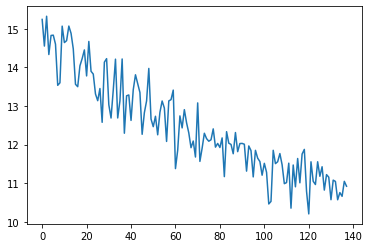

In [36]:
plt.figure()
plt.plot(losses)
plt.show()

In [38]:
i = 90 # program we are testing
task = QuantumTask(i,lambda n_qubit, program=matched_programs[i]: dc.program.Program.parse(program[0]).evaluate([])(f_no_op(n_qubit)))
code =  dc.program.Program.parse(matched_programs[i][1])
embedding = recognition_model.featureExtractor.featuresOfTask(task)
predicted_grammar_of_task = recognition_model(embedding)
grammar.logLikelihood(code.infer(),code), predicted_grammar_of_task.logLikelihood(code.infer(),code)


(-12.476649250079014, tensor([-8.9481], grad_fn=<AddBackward0>))

In [39]:
print_circuit(dc.program.Program.parse(matched_programs[i][1]).evaluate([])(no_op(4)))

               
q_0: ──■───────
     ┌─┴─┐┌───┐
q_1: ┤ X ├┤ H ├
     ├───┤└───┘
q_2: ┤ H ├─────
     └───┘     
q_3: ──────────
               


In [40]:
task = get_task_from_name("cnot_10",tasks)
code = dc.program.Program.parse("(lambda (cnot (minv(mv( $0)))))")

embedding = recognition_model.featureExtractor.featuresOfTask(task)
predicted_grammar_of_task = recognition_model(embedding)

grammar.logLikelihood(code.infer(),code), predicted_grammar_of_task.logLikelihood(code.infer(),code)

NameError: name 'tasks' is not defined

In [181]:
task = get_task_from_name("swap_01",tasks)
code = dc.program.Program.parse("(lambda  (cnot(minv(mv_r(cnot(minv (mv (cnot  $0))))))))")

embedding = recognition_model.featureExtractor.featuresOfTask(task)
predicted_grammar_of_task = recognition_model(embedding)

grammar.logLikelihood(code.infer(),code), predicted_grammar_of_task.logLikelihood(code.infer(),code)

(-15.567281192442506, tensor([-17.7888], grad_fn=<AddBackward0>))

In [182]:
task = get_task_from_name("swap_0n",tasks)
code = dc.program.Program.parse("(lambda ((  (rep (dec(dec(size $0))) (lambda ((cnot(minv(mv_r(cnot(minv (mv (cnot(mv_r $0)))))))))) )  (mv_r( (rep (dec(size $0)) (lambda (mv((cnot(minv(mv_r(cnot(minv (mv (cnot $0)))))))))) )  $0 )))))")

embedding = recognition_model.featureExtractor.featuresOfTask(task)
predicted_grammar_of_task = recognition_model(embedding)

grammar.logLikelihood(code.infer(),code), predicted_grammar_of_task.logLikelihood(code.infer(),code)

(-53.633315382926966, tensor([-54.5993], grad_fn=<AddBackward0>))

In [183]:
task.logLikelihood(code)

0.0

---

#### Enumerating arithmetic

In [ ]:
counter = 0
for i in iterator:
    counter +=1
    if counter<100:
        print(i)
    else: break

[(lambda 0)]


(lambda $0)
(lambda (inc $0))
(lambda (dec $0))
(lambda (inc (inc $0)))
(lambda (dec (dec $0)))
(lambda (inc (inc (inc $0))))
(lambda (dec (dec (dec $0))))
(lambda (inc (inc (inc (inc $0)))))
(lambda (dec (dec (dec (dec $0)))))
(lambda (inc (inc (inc (inc (inc $0))))))
(lambda (dec (dec (dec (dec (dec $0))))))
(lambda (inc (inc (inc (inc (inc (inc $0)))))))
(lambda (dec (dec (dec (dec (dec (dec $0)))))))
(lambda (inc (inc (inc (inc (inc (inc (inc $0))))))))
(lambda (dec (dec (dec (dec (dec (dec (dec $0))))))))
(lambda (inc (inc (inc (inc (inc (inc (inc (inc $0)))))))))
(lambda (dec (dec (dec (dec (dec (dec (dec (dec $0)))))))))
(lambda (inc (inc (inc (inc (inc (inc (inc (inc (inc $0))))))))))
(lambda (dec (dec (dec (dec (dec (dec (dec (dec (dec $0))))))))))
(lambda (inc (inc (inc (inc (inc (inc (inc (inc (inc (inc $0)))))))))))
(lambda (dec (dec (dec (dec (dec (dec (dec (dec (dec (dec $0)))))))))))
(lambda (inc (inc (inc (inc (inc (inc (inc (inc (inc (inc (inc $0))))))))))))
(lambda (d

TODO:

- [x] Explore enumeration: why so few programs are matched?
- [x] Add EMBED gate in the restricted set
- [NO] Add swap in the restricted set to see if matched programs increase
- [x] Augment the dataset by merging two programs
- Try to merge two low-level programs and see if we find one solution in the full
- Transformer: special aggregator token as a vertex
  - [x] special edge token aggregator which connects all vertices and only look at it
  - [x] eval and train mode in pytorch
  - [ ] generalize with multiple qubits: embedding should take into account multiple values of n_qubits
  - [ ] optimize performance
  - mask to the largest vertex size and batch training of the transformer (now we are using a for loop, which slows down the calculation)